In [92]:
import pandas as pd
import geopandas as gpd
import argparse
import numpy as np
import datetime
from datetime import datetime as dtime
from shapely.geometry import Point, LineString
from shapely.geometry import asPoint

# set the datetime epoch:
epoch = dtime.strptime('Q2020-01-01T00:00:00.000Z', "Q%Y-%m-%dT%H:%M:%S.%f%z")


In [93]:
# this is the boat_id of the reference and is just for the jn - will be an arg in the actual fcn
ref_id = 3

In [94]:
def lonlat2UTM(lonlat):  # lonlat is [long, lat]
    utm = (np.floor((lonlat[0] + 180) / 6) % 60) + 1
    if(lonlat[1] > 0): 
        utm = utm + 32600
    else:
        utm = utm + 32700
    return int(utm)



In [95]:
fname = "/Users/sdynes/IBI/MIT_t4t/tech4techs/pi_code/mqtt_data/server_2022_248_215209"
f = open(fname, "rb")
pl = f.read()

In [96]:
headers = ['geometry','boat_id', 'msg_id', 'time']
raw_gdf = gpd.GeoDataFrame(columns=headers, crs="EPSG:4326")

fp = 0
dsize = len(pl)
while (fp < dsize):
    if (pl[fp+0:fp+4] == b'otle'):
        mqtt_msg_index = int.from_bytes(pl[fp+4:fp+6], byteorder='big', signed = True)
        llat = int.from_bytes(pl[fp+6:fp+11], byteorder='big', signed = True)* 1e-9
        llong = int.from_bytes(pl[fp+11:fp+16], byteorder='big', signed = True)* 1e-9
        err_2d = int.from_bytes(pl[fp+16:fp+17], byteorder='big', signed = False)/200
        meas_time = epoch + datetime.timedelta(seconds = (int.from_bytes(pl[fp+17:fp+22], byteorder='big', signed = True)/10))
        course_t = int.from_bytes(pl[fp+22:fp+23], byteorder='big', signed = True)*360/256
        boat_id = int.from_bytes(pl[fp+23:fp+24], byteorder='big', signed = True)
    else:
        print("first four bytes are not otle at offset " + str(fp))
        exit(1)
    
        # put data into raw_gdf
    raw_gdf = raw_gdf.append({"geometry":Point(llong,llat), "boat_id":int(boat_id), "msg_id": int(mqtt_msg_index),
                              "time": pd.Timestamp(meas_time)},ignore_index=True)
    raw_gdf.geometry.crs="EPSG:4326"

    # increment the file pointer
    fp += 24

    # should have put the data into the gdf



In [97]:
# change geometry into meters
    
if (len(raw_gdf) >  0):
    utm = lonlat2UTM([raw_gdf.geometry[0].x,raw_gdf.geometry[0].y ])
    proj = "EPSG:" + str(utm)
    raw_gdf.geometry = raw_gdf.geometry.to_crs(proj)


In [103]:
headers = ['distance','boat_id', 'percent_dropped']



In [104]:
# figure out the time things
t_max = np.max(raw_gdf.time)
t_min = np.min(raw_gdf.time)
min_t = t_min
max_t = min_t + datetime.timedelta(minutes=1)
num_windows = int((t_max - t_min).total_seconds()/60)

# create a list to put the calculated values in
# headers = ['distance','boat_id', 'percent_dropped', 'time']
# num_windows * number of boat_ids
tmp_list = np.zeros(shape=(num_windows * len(raw_gdf.boat_id.unique()), len(headers))) - 1  # so all boat_ids are -1
tmp_list_i = 0

In [105]:
# loop thru and take 1-minute windows, calculate the 
# distances from the reference device, and the number of dropped packets
for i in range(0, num_windows):
    tmp_d = raw_gdf[(raw_gdf.time >= min_t) & (raw_gdf.time < max_t)]
    
    # get the mean x,y for the reference boat_id
    a = tmp_d[tmp_d.boat_id == ref_id]
    ref_x = np.mean(a.geometry.x)
    ref_y = np.mean(a.geometry.y)
    
    # for each boat_id, loop thru and calculate/enter the data in the tmp_list array
    for j in (tmp_d.boat_id.unique()):
        a = tmp_d[tmp_d.boat_id == ref_id]
        percent_dropped = 1.0-len(a.msg_id)/(1+np.max(a.msg_id)-np.min(a.msg_id))
        time = np.mean(a.time)
        distance = np.sqrt((ref_x - np.mean(a.geometry.x))**2 + (ref_y - np.mean(a.geometry.y))**2)
        tmp_list[tmp_list_i] = [distance, j, percent_dropped]
        tmp_list_i += 1
        
    


In [106]:

df = pd.DataFrame(tmp_list, columns = headers)

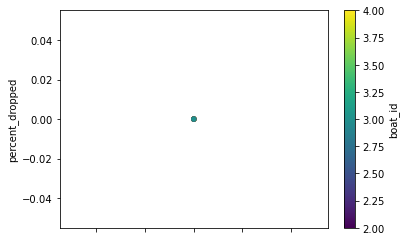

In [107]:
ax2 = df.plot.scatter(x='distance',

                      y='percent_dropped',

                      c='boat_id',

                      colormap='viridis')

In [108]:
df

distance  boat_id  percent_dropped
0        0.0      4.0              0.0
1        0.0      2.0              0.0
2        0.0      3.0              0.0
3        0.0      4.0              0.0
4        0.0      2.0              0.0
5        0.0      3.0              0.0
6        0.0      4.0              0.0
7        0.0      2.0              0.0
8        0.0      3.0              0.0
9        0.0      4.0              0.0
10       0.0      2.0              0.0
11       0.0      3.0              0.0

In [82]:
tmp_list = np.zeros(shape=(num_windows * len(raw_gdf.boat_id.unique()), len(headers))) - 1  # so all boat_ids are -1
tmp_list_i = 0


In [84]:
tmp_list[tmp_list_i]=[1,2.3,4.5,7]


In [88]:
b = pd.DataFrame(tmp_list, columns = headers)


In [89]:
b

distance  boat_id  percent_dropped  time
0        1.0      2.3              4.5   7.0
1       -1.0     -1.0             -1.0  -1.0
2       -1.0     -1.0             -1.0  -1.0
3       -1.0     -1.0             -1.0  -1.0
4       -1.0     -1.0             -1.0  -1.0
5       -1.0     -1.0             -1.0  -1.0
6       -1.0     -1.0             -1.0  -1.0
7       -1.0     -1.0             -1.0  -1.0
8       -1.0     -1.0             -1.0  -1.0
9       -1.0     -1.0             -1.0  -1.0
10      -1.0     -1.0             -1.0  -1.0
11      -1.0     -1.0             -1.0  -1.0